# Compare cornerplots

Checking the posteriors between jim and bilby

## Preamble

In [16]:
import os
import copy
import numpy as np 
import json 
import matplotlib.pyplot as plt
import corner
import h5py

In [17]:
params = {"axes.grid": True,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(params)

# Improved corner kwargs
default_corner_kwargs = dict(bins=40, 
                        smooth=1., 
                        show_titles=False,
                        label_kwargs=dict(fontsize=16),
                        title_kwargs=dict(fontsize=16), 
                        color="blue",
                        plot_density=True, 
                        plot_datapoints=False, 
                        fill_contours=True,
                        max_n_ticks=4, 
                        min_n_ticks=3,
                        density = True,
                        truth_color = "black")

In [18]:
bilby_keys = ["chirp_mass",
              "mass_ratio",
              "chi_1",
              "chi_2",
              "luminosity_distance",
              "geocent_time",
              "phase",
              "theta_jn",
              "psi",
              "ra",
              "dec"
]

## Make the plot

Specify the directory id, i.e., `working_X`.

(4802, 11)
(175000, 11)
(5834, 11)


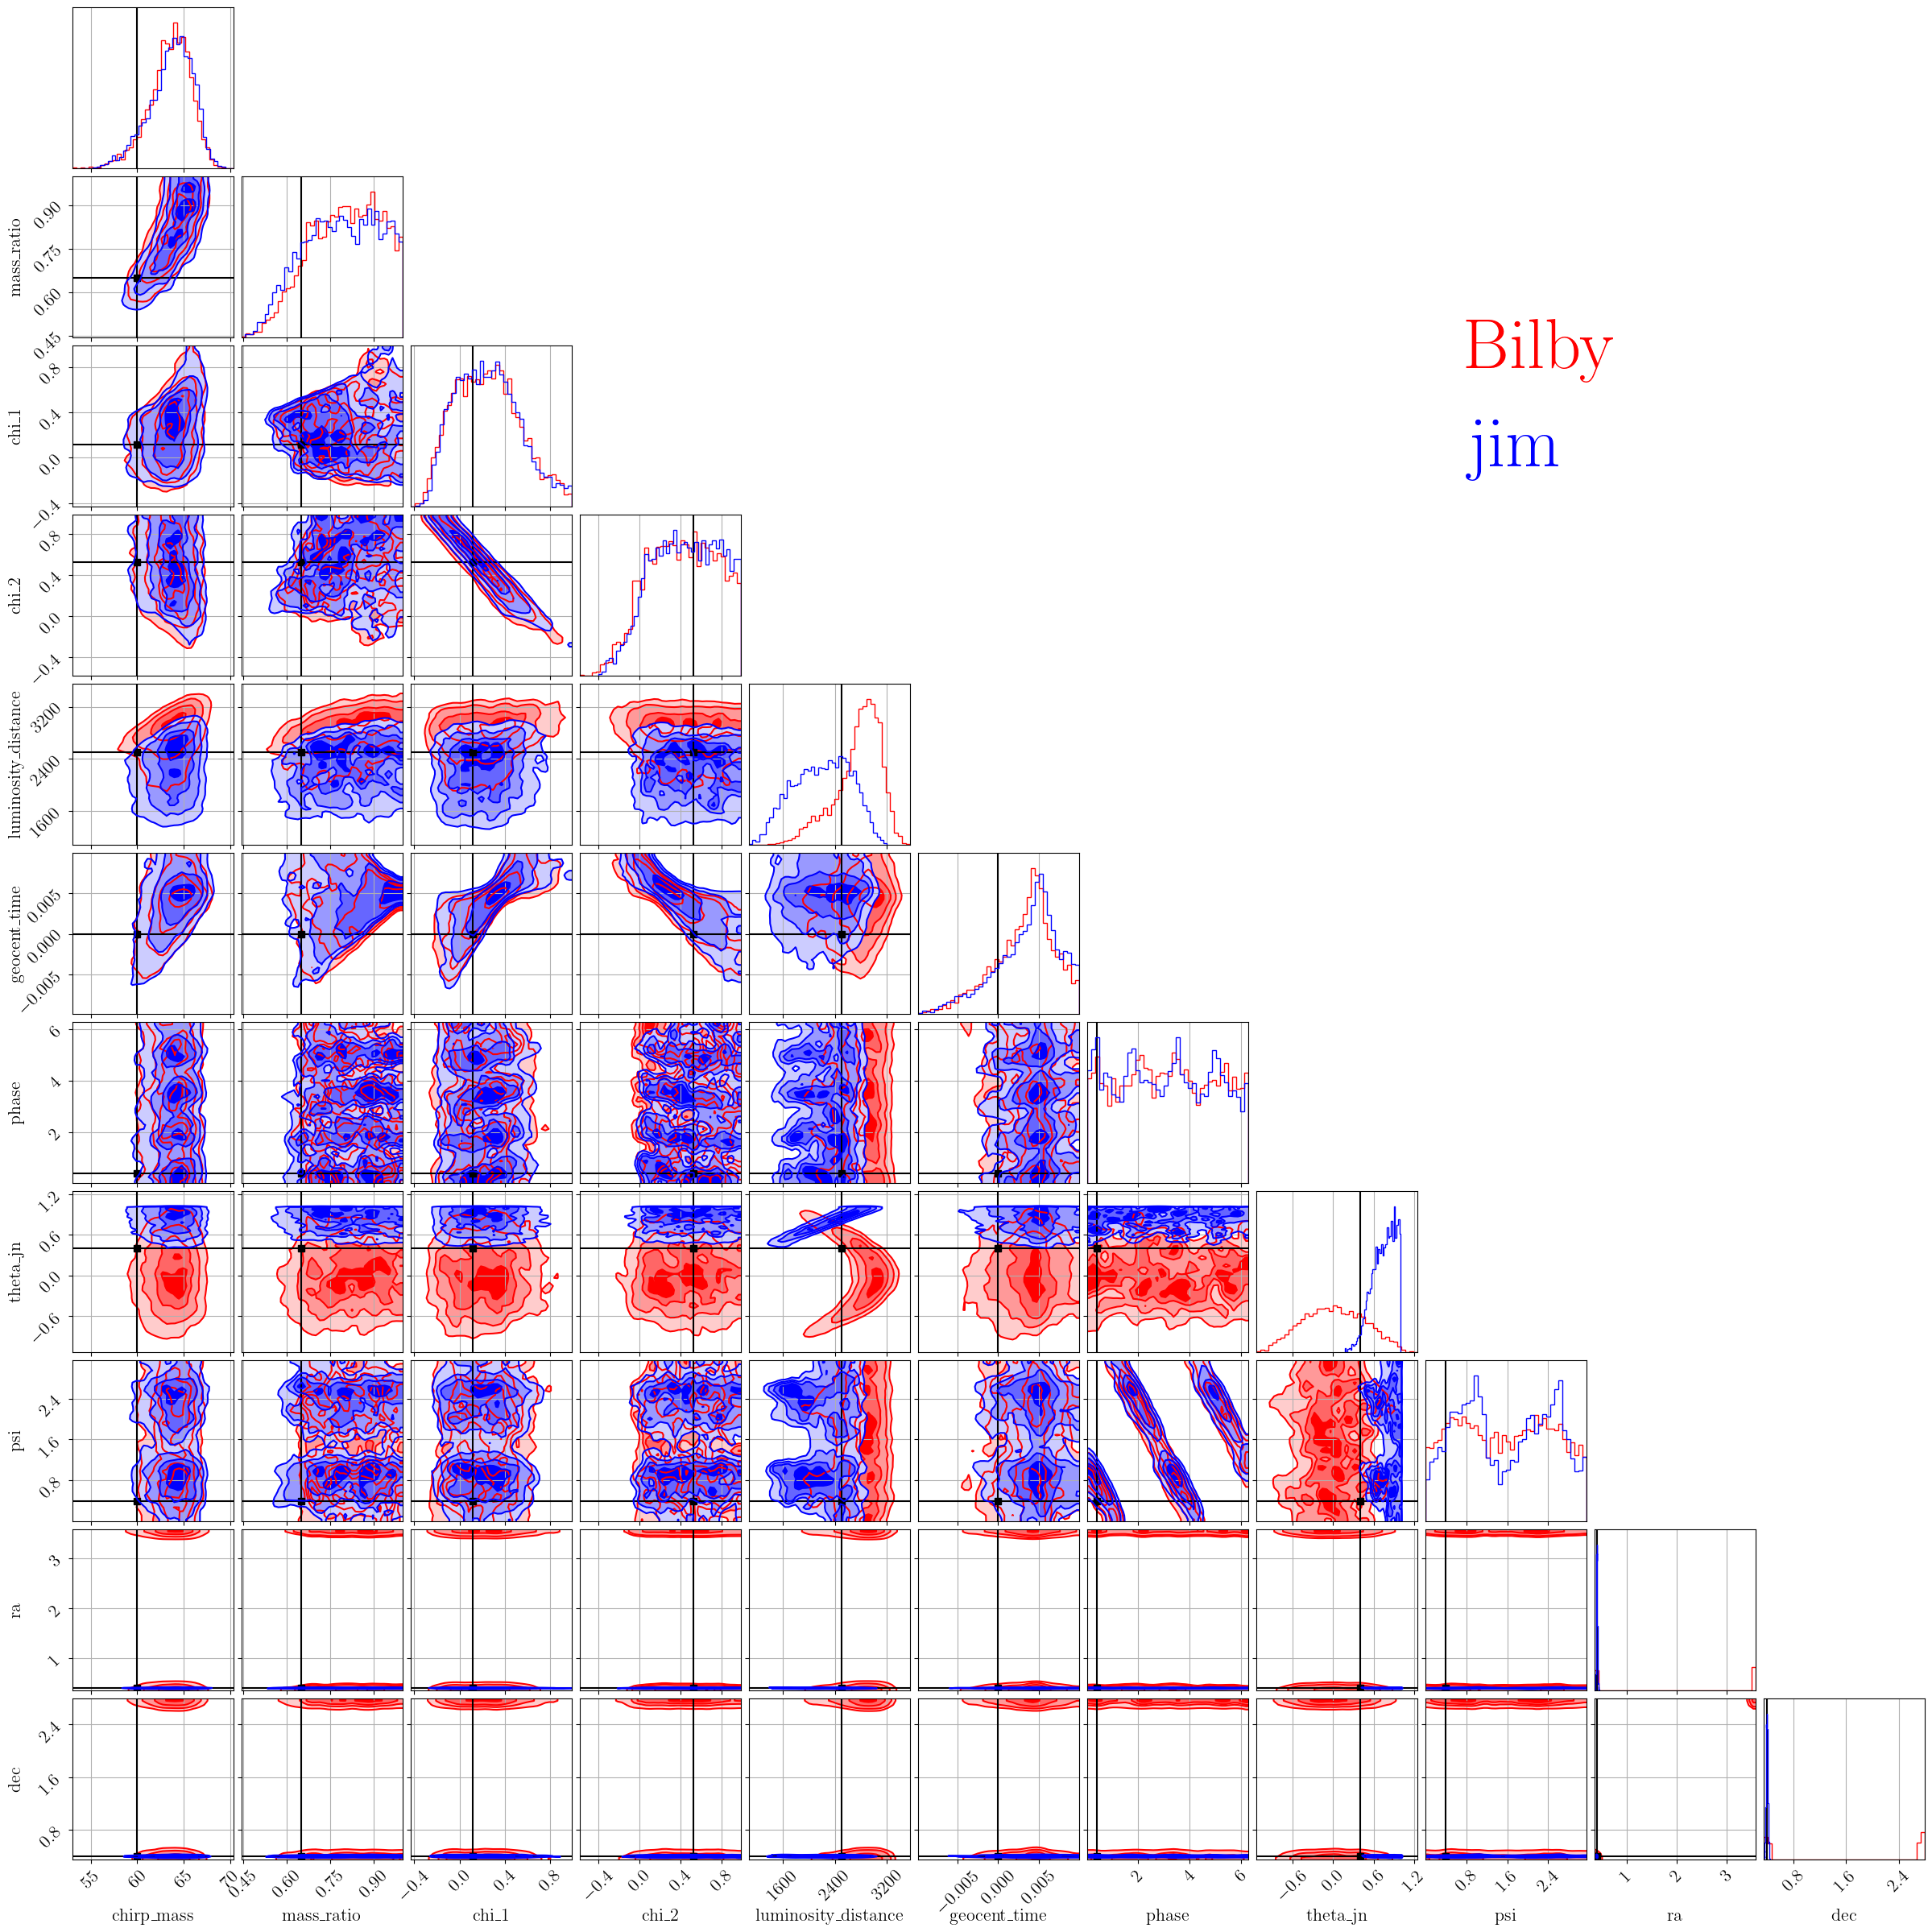

In [19]:
### Choose ID here, and get the outdir
id = 2
outdir = os.path.join(os.getcwd(), f'working_{id}')
###

### Load bilby
bilby_outdir = os.path.join(outdir, 'bilby')
bilby_results_file = os.path.join(bilby_outdir, 'bbh_0_result.hdf5')
with h5py.File(bilby_results_file, 'r') as f:
    bilby_posterior = f["posterior"]
    bilby_posterior = np.array([bilby_posterior[key] for key in bilby_keys]).T
    
    truths_dict = f["injection_parameters"]
    # truths = np.array([truths_dict[key] for key in bilby_keys])
    
    truths = []
    for key in bilby_keys:
        truths.append(truths_dict[key][()])
    truths = np.array(truths)
    
print(np.shape(bilby_posterior))

### Load jim
jim_outdir = os.path.join(outdir, 'jim') # TODO: move!

jim_file = os.path.join(jim_outdir, 'results_production.npz')
jim_posterior = np.load(jim_file)["chains"]
jim_posterior = np.reshape(jim_posterior, (-1, jim_posterior.shape[-1]))
print(np.shape(jim_posterior))

# Thinning the jim samples a bit to make it easier for corner to handle
jump = 30
jim_posterior = jim_posterior[::jump, :]
print(np.shape(jim_posterior))

samples_dict = {"bilby": bilby_posterior, "jim": jim_posterior}
colors_dict = {"bilby": "red", "jim": "blue"}

for i, key in enumerate(["bilby", "jim"]):
    samples = samples_dict[key]
    color = colors_dict[key]

    corner_kwargs = copy.deepcopy(default_corner_kwargs)
    corner_kwargs["color"] = color
    corner_kwargs["hist_kwargs"] = {"color": color, "density": True}
    if i == 0:
        fig =  corner.corner(bilby_posterior, truths=truths, labels=bilby_keys, **corner_kwargs)
    else:
        corner.corner(jim_posterior, fig=fig, **corner_kwargs)

fs = 64
plt.text(0.75, 0.8, "Bilby", color="red", fontsize=fs, transform=plt.gcf().transFigure)
plt.text(0.75, 0.75, "jim", color="blue", fontsize=fs, transform=plt.gcf().transFigure)

# Save the figure
plt.savefig(os.path.join(outdir, "comparison_corner.png"), bbox_inches = 'tight')
plt.show()